# Investigating the correlation between disease composition at taxonomically-related species

### Import modules

In [1]:
from collections import defaultdict
from itertools import combinations
import random

import logging
import pandas as pd
from tqdm import tqdm
    
# Stats
from scipy.stats import mannwhitneyu
from scipy.stats import pearsonr
from statannot import add_stat_annotation

# Viz
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

# Import taxonomy
from utils import get_genus_and_family_info_for_plants

In [2]:
%matplotlib inline

In [3]:
logging.disable()
pd.options.mode.chained_assignment = None

In [4]:
DATA_DIR = '../data/processed'

### Load plant-disease evidences

In [5]:
collapsed_plant_disease_df = pd.read_csv(
    f'{DATA_DIR}/plant_disease_collapsed.tsv',
    sep='\t',
    low_memory=False
)

In [6]:
literature_data = collapsed_plant_disease_df[
    collapsed_plant_disease_df['database'] == 'bern2'
]

plant_lit_ids = set(literature_data['plant_curie'].to_list())

literature_data.shape, len(plant_lit_ids)

((129539, 5), 4413)

In [7]:
database_data = collapsed_plant_disease_df[
    collapsed_plant_disease_df['database'] != 'bern2'
]

plant_db_ids = set(database_data['plant_curie'].to_list())

database_data.shape, len(plant_db_ids)

((43163, 5), 2338)

In [8]:
# Total plant count
len(plant_lit_ids.union(plant_db_ids))

5636

### Get genus mapping for plants

In [9]:
genus_to_species_lit, family_to_species_lit = get_genus_and_family_info_for_plants(plant_lit_ids)

order genus: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16768/16768 [00:00<00:00, 20356.48it/s]


In [10]:
genus_to_species_db, family_to_species_db = get_genus_and_family_info_for_plants(plant_db_ids)

order genus: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16768/16768 [00:00<00:00, 19870.29it/s]


In [11]:
disease_vector = set(collapsed_plant_disease_df['disease_curie'].to_list())
len(disease_vector)

23

### Prepare plant-disease dicts

In [12]:
def get_non_binary_dict(df:pd.DataFrame):
    """Get plant-disease data dictionary based on citation counts"""
    
    non_binary_dict = {}
        
    for plant_curie, disease_curie, evidence in tqdm(
        df[['plant_curie', 'disease_curie', 'evidence']].values
    ):
        pmid = evidence.split('_')[0]

        if plant_curie not in non_binary_dict:
            non_binary_dict[plant_curie] = defaultdict(set)

        non_binary_dict[plant_curie][disease_curie].add(pmid)
    return non_binary_dict

In [13]:
disease_literature_non_binary_dict = get_non_binary_dict(literature_data)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129539/129539 [00:00<00:00, 457214.99it/s]


In [14]:
disease_db_non_binary_dict = get_non_binary_dict(database_data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43163/43163 [00:00<00:00, 478854.87it/s]


### Calculate chemical similarity for plants in the same genus or family

In [15]:
def calculate_pearson(plant_1, plant_2, species_to_vectors):
    """Calculate pearson coeffiencient."""
    diseases_plant_1_dict = species_to_vectors[plant_1]
    diseases_plant_2_dict = species_to_vectors[plant_2]
    
    elements_in_plant_1 = []
    elements_in_plant_2 = []
    
    for disease in disease_vector:
        if disease in diseases_plant_1_dict:
            elements_in_plant_1.append(len(diseases_plant_1_dict[disease]))
        else:
            elements_in_plant_1.append(0)
            
        if disease in diseases_plant_1_dict:
            elements_in_plant_2.append(len(diseases_plant_2_dict[disease]))
        else:
            elements_in_plant_2.append(0)
    try:
        corr = pearsonr(elements_in_plant_1, elements_in_plant_2)
    except:
        corr = None, None
    
    return corr


def calculate_overlap_for_taxa_level(
    taxonomy_dict,
    species_to_disease_dict,
    pair_type,
):
    similarity_list = []
    skipped = 0
    
    for _, species in tqdm(
        taxonomy_dict.items(),
        desc='calculating similarity...',
        total=len(taxonomy_dict),
    ):
        # Not enough species to calculate similarity
        if len(species) <= 1:
            skipped += 1
            continue
                        
        for plant_1, plant_2 in combinations(species, 2):
            
            if (
                plant_1 not in species_to_disease_dict or 
                plant_2 not in species_to_disease_dict
            ):
                continue
            
            # pearson coefficient
            corr_coeff, p_val = calculate_pearson(
                plant_1, plant_2, species_to_disease_dict
            )
            
            if not corr_coeff:
                continue
            
            similarity_list.append({
                'plant_1': plant_1,
                'plant_2': plant_2,
                'pair_type': pair_type,
                'pearson_coefficient': corr_coeff,
            })    
            
    return pd.DataFrame(similarity_list)

In [16]:
lit_genus_similarity = calculate_overlap_for_taxa_level(
    taxonomy_dict=genus_to_species_lit, # genus to species
    species_to_disease_dict=disease_literature_non_binary_dict, # plant(s) -> disease ids
    pair_type='Same genus',
)

lit_family_similarity = calculate_overlap_for_taxa_level(
    taxonomy_dict=family_to_species_lit, # family to species
    species_to_disease_dict=disease_literature_non_binary_dict, # plant(s) -> disease ids
    pair_type='Same family',
)

calculating similarity...:   0%|                                                                                                                   | 0/2083 [00:00<?, ?it/s]/Users/yojana/anaconda3/envs/kg-sources/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
calculating similarity...:   0%|                                                                                                                    | 0/339 [00:00<?, ?it/s]/Users/yojana/anaconda3/envs/kg-sources/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
calculating similarity...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 339/339 [00:29<00:00, 11.61it/s]

In [17]:
db_genus_similarity = calculate_overlap_for_taxa_level(
    taxonomy_dict=genus_to_species_db, # genus to species
    species_to_disease_dict=disease_db_non_binary_dict, # plant(s) -> disease ids
    pair_type='Same genus',
)

db_family_similarity = calculate_overlap_for_taxa_level(
    taxonomy_dict=family_to_species_db, # family to species
    species_to_disease_dict=disease_db_non_binary_dict, # plant(s) -> disease ids
    pair_type='Same family',
)

calculating similarity...:   0%|                                                                                                                   | 0/1185 [00:00<?, ?it/s]/Users/yojana/anaconda3/envs/kg-sources/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
calculating similarity...:   0%|                                                                                                                    | 0/226 [00:00<?, ?it/s]/Users/yojana/anaconda3/envs/kg-sources/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
calculating similarity...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [00:10<00:00, 21.53it/s]

### Calculate chemical similarity for non taxonomically related plants

In [18]:
def calculate_baseline_overlap(
    all_plants,
    family_taxonomy,
    species_to_disease_dict,
):
    """Calculate overlap (disease/chemical) for plants ensuring that they are not belonging 
    to the same family (taxonomically-related)."""
    
    # List to store the similarity/overlap for these non-taxonomically plants
    similarity_list = []
        
    species_to_family = {
        plant: family
        for family, species in family_taxonomy.items()
        for plant in species
    }
    
    outdated_ids = set()
    
    # Ensure it is a list
    all_plants = list(all_plants)
    
    while len(similarity_list) < 100000:
        # Get two random plants
        plant_1, plant_2 = random.choices(all_plants, k=2)
        
        # Plants with a wrong identifier
        if plant_1 not in species_to_family:
            outdated_ids.add(plant_1)
            continue
            
        if plant_2 not in species_to_family:
            outdated_ids.add(plant_2)
            continue
                
        # Skip if the plants belong to the same family
        if species_to_family[plant_1] == species_to_family[plant_2]:
            continue  
        
        # pearson coefficient
        corr_coeff, p_val = calculate_pearson(
            plant_1, plant_2, species_to_disease_dict
        )
        
        if not corr_coeff:
            continue

        similarity_list.append({
            'plant_1': plant_1,
            'plant_2': plant_2,
            'pair_type': 'Random',
            'pearson_coefficient': corr_coeff,
        })
            
    return pd.DataFrame(similarity_list), outdated_ids

In [19]:
lit_baseline_similarity, lit_outdated_ids = calculate_baseline_overlap(
    all_plants=plant_lit_ids,
    family_taxonomy=family_to_species_lit,  # family to species
    species_to_disease_dict=disease_literature_non_binary_dict, # plant(s) -> chemical ids,
)

/Users/yojana/anaconda3/envs/kg-sources/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [20]:
db_baseline_similarity, db_outdated_ids = calculate_baseline_overlap(
    all_plants=plant_db_ids,
    family_taxonomy=family_to_species_db,  # family to species
    species_to_disease_dict=disease_db_non_binary_dict, # plant(s) -> chemical ids
)

/Users/yojana/anaconda3/envs/kg-sources/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [21]:
len(lit_outdated_ids), len(db_outdated_ids)

(11, 10)

In [22]:
lit_merged_df = pd.concat([
    lit_genus_similarity,
    lit_family_similarity,
    lit_baseline_similarity,
])

In [23]:
lit_merged_df.to_csv(f'{DATA_DIR}/literature_based_correlation_data.tsv', sep='\t', index=False)

In [24]:
df_merged_df = pd.concat([
    db_genus_similarity,
    db_family_similarity,
    db_baseline_similarity,
])

In [25]:
df_merged_df.to_csv(f'{DATA_DIR}/database_based_correlation_data.tsv', sep='\t', index=False)

### Plant-plant pair counts

In [26]:
lit_genus_pairs = lit_merged_df[lit_merged_df['pair_type'] == 'Same genus']
db_genus_pairs = df_merged_df[df_merged_df['pair_type'] == 'Same genus']

# Get pairs
lit_genus_pairs['pairs'] = lit_genus_pairs['plant_1'] + '_' + lit_genus_pairs['plant_2']
db_genus_pairs['pairs'] = db_genus_pairs['plant_1'] + '_' + db_genus_pairs['plant_2']


# All pairs
lit_gpairs = set(lit_genus_pairs['pairs'].values)
db_gpairs = set(db_genus_pairs['pairs'].values)

genus_pairs = lit_gpairs.union(db_gpairs)
len(genus_pairs), len(lit_gpairs), len(db_gpairs)

(13789, 10962, 3533)

In [27]:
lit_fam_pairs = lit_merged_df[lit_merged_df['pair_type'] == 'Same family']
db_fam_pairs = df_merged_df[df_merged_df['pair_type'] == 'Same family']

# Get pairs
lit_fam_pairs['pairs'] = lit_fam_pairs['plant_1'] + '_' + lit_fam_pairs['plant_2']
db_fam_pairs['pairs'] = db_fam_pairs['plant_1'] + '_' + db_fam_pairs['plant_2']


# All pairs
lit_fpairs = set(lit_fam_pairs['pairs'].values)
db_fpairs = set(db_fam_pairs['pairs'].values)

fam_pairs = lit_fpairs.union(db_fpairs)
len(fam_pairs), len(lit_fpairs), len(db_fpairs)

(273624, 204877, 82982)

### Similarity plot

In [28]:
sns.set(context='poster')
mpl.rcParams['figure.dpi'] = 400

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Same genus v.s. Same family: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=1.208e+09
Same family v.s. Random: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.791e-71 U_stat=1.052e+10
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Same genus v.s. Same family: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=1.940e+08
Same family v.s. Random: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.390e-24 U_stat=4.215e+09


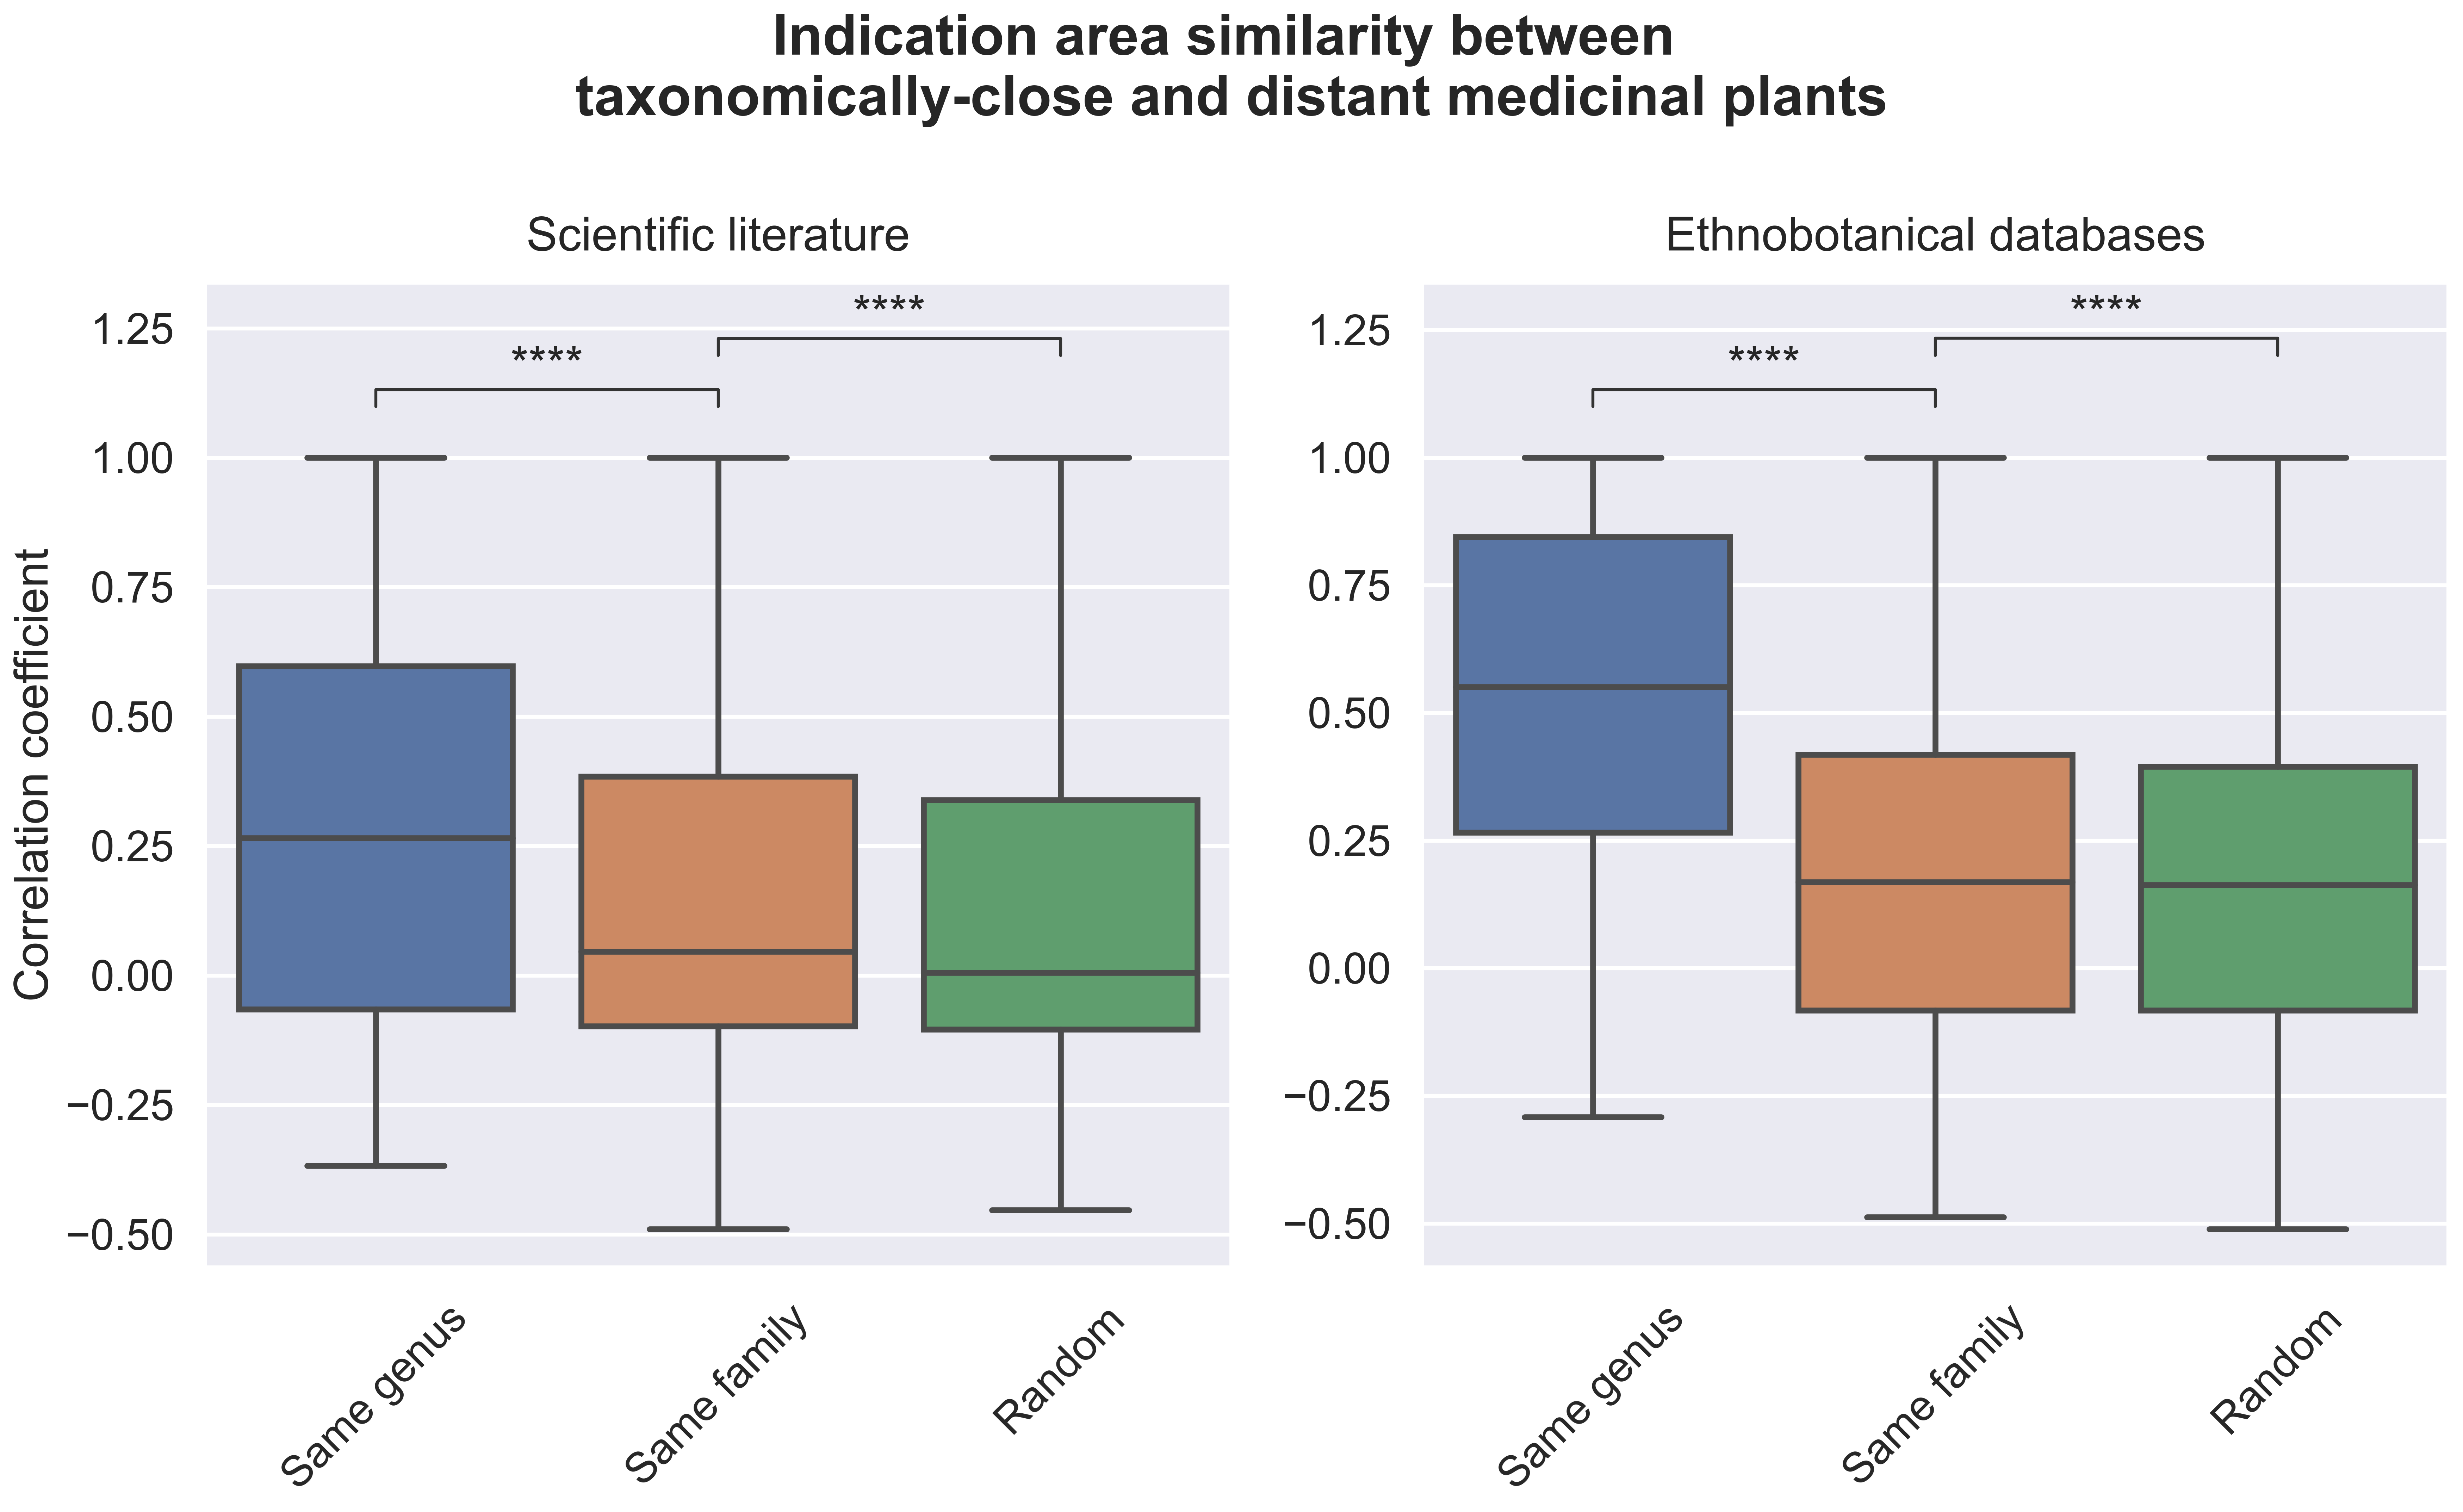

In [29]:
fig = plt.figure(figsize=(18, 11)) 

ax1 = plt.subplot2grid(shape=(1,2), loc=(0,0), colspan=1)
ax2 = plt.subplot2grid((1,2), (0,1), colspan=1)

suptitle = plt.suptitle(
    'Indication area similarity between \ntaxonomically-close and distant medicinal plants',
    y=0.99,
    fontweight='bold'
)

sns.boxplot(data=lit_merged_df, x='pair_type', y='pearson_coefficient', ax=ax1)
add_stat_annotation(
    data=lit_merged_df,
    x='pair_type',
    y='pearson_coefficient',
    ax=ax1,
    box_pairs=[
       ("Same genus", "Same family"), 
       ("Same family", "Random")
    ],
    test='Mann-Whitney',
    text_format='star', 
    line_offset=0,
    text_offset=0,
)

# Rotate ticks X
ax1.xaxis.set_tick_params(rotation=45)

# Avoids that 1.2 comes in the plot
# ax1.set_ylim([-0.05, 1.19])

# Set Y and X ticks
ax1.set_ylabel("Correlation coefficient")
ax1.set_xlabel("")
ax1.set_title("Scientific literature", y=1.02)

sns.boxplot(data=df_merged_df, x='pair_type', y='pearson_coefficient', ax=ax2)
add_stat_annotation(
    data=df_merged_df,
    x='pair_type',
    y='pearson_coefficient',
    ax=ax2,
    box_pairs=[
       ("Same genus", "Same family"), 
       ("Same family", "Random")
    ],
    test='Mann-Whitney',
    text_format='star', 
    line_offset=0,
    text_offset=0,
)

# Rotate ticks X
ax2.xaxis.set_tick_params(rotation=45)

# Avoids that 1.2 comes in the plot
# ax2.set_ylim([-0.05, 1.19])

# Set Y and X ticks
ax2.set_ylabel("")
ax2.set_xlabel("")

ax2.set_title("Ethnobotanical databases", y=1.02)
    
plt.tight_layout()
plt.savefig(
    f'../data/figures/figure_2.png',
    dpi=400,
    bbox_inches='tight', 
    bbox_extra_artists=[suptitle],
)
plt.show()

In [30]:
for col in lit_merged_df.pair_type.unique():
    info = lit_merged_df[lit_merged_df.pair_type == col]
    print(
        f'Disease area similarity (literature) for {col} \
        mean: {info["pearson_coefficient"].mean():.3f}, \
        median: {info["pearson_coefficient"].median():.3f}'
    )

Disease area similarity (literature) for Same genus         mean: 0.304,         median: 0.265
Disease area similarity (literature) for Same family         mean: 0.156,         median: 0.046
Disease area similarity (literature) for Random         mean: 0.133,         median: 0.005


In [31]:
for col in df_merged_df.pair_type.unique():
    info = df_merged_df[df_merged_df.pair_type == col]
    print(
        f'Disease area similarity (databases) for {col} \
        mean: {info["pearson_coefficient"].mean():.3f}, \
        median: {info["pearson_coefficient"].median():.3f}'
    )

Disease area similarity (databases) for Same genus         mean: 0.519,         median: 0.550
Disease area similarity (databases) for Same family         mean: 0.195,         median: 0.168
Disease area similarity (databases) for Random         mean: 0.177,         median: 0.163
